In [11]:
import os
import numpy as np
import warnings  # Add warnings module to suppress sklearn warnings
ROOT_PATH = 'D:\\projects\\spam-detection2\\'
DATA_PATH = os.path.abspath(os.path.join(ROOT_PATH, '../spam-detection-data/'))
DATA_PATH

'D:\\projects\\spam-detection-data'

In [2]:
# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy")
# warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

### Download and Preprocess Data

In [3]:
from utils.preprocessor import prepare_data
prepare_data()

Data already prepared. Loading from disk...

Data preparation complete!
Train: 4837, Test: 1210


### SHAP & LIME Explainability for CNN Model

In [4]:
from utils.explainability import explain_cnn_with_shap, explain_cnn_with_lime
import shap
import matplotlib.pyplot as plt
import torch
import pandas as pd
import random
from utils.preprocessor import load_glove_embeddings
from utils.functions import build_vocab

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
# Load preprocessed data (assumes PKLs/CSVs are available in data/processed/)
train_df = pd.read_pickle(ROOT_PATH + 'data/processed/train.pkl')
test_df = pd.read_pickle(ROOT_PATH + 'data/processed/test.pkl')

set_seed(42)
word2idx = build_vocab(train_df['text'])

In [7]:
# Load GloVe embeddings
GLOVE_PATH = os.path.join(DATA_PATH, 'raw/glove.6B/glove.6B.300d.txt')
embedding_dim = 300
pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [13]:
# Load your trained CNN model and data as in your training code
from models.cnn import SpamCNN
from utils.explainability import show_in_notebook

# Example: (adjust paths and variables as needed)
model = SpamCNN(vocab_size=len(word2idx), embedding_dim=300, pretrained_embeddings=pretrained_embeddings)
model.load(ROOT_PATH + 'trained_models/spam_cnn.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

max_len = 200

def cnn_tokenizer(text, max_len=max_len):
    idxs = [word2idx.get(token, word2idx['<UNK>']) for token in text.split()]
    if len(idxs) < max_len:
        idxs += [word2idx['<PAD>']] * (max_len - len(idxs))
    else:
        idxs = idxs[:max_len]
    return idxs

sample_texts = test_df['text'].iloc[:10].tolist()

# SHAP explainability
rng = np.random.default_rng(42)  # Create a random number generator
shap_values, test_inputs = explain_cnn_with_shap(model, cnn_tokenizer, sample_texts, device, max_len=max_len, num_samples=10, rng=rng)

# Create a reverse mapping from index to word
idx2word = {idx: word for word, idx in word2idx.items()}

# Convert token IDs to words for better visualization
def map_token_ids_to_words(token_ids):
    return [idx2word.get(int(token_id), '<UNK>') for token_id in token_ids]

# Get feature names from actual words in the inputs
feature_names = []
for i in range(test_inputs.shape[1]):
    # Find the most common non-padding word at this position
    unique_tokens, counts = np.unique(test_inputs[:, i].cpu().numpy(), return_counts=True)
    most_common_token = unique_tokens[np.argmax(counts)]
    if most_common_token != word2idx['<PAD>']:
        feature_names.append(f'{i}:{idx2word.get(int(most_common_token), "<UNK>")}')
    else:
        feature_names.append(f'{i}:<PAD>')

# Convert inputs back to numpy array
inputs_np = test_inputs.cpu().numpy()

# Only select the top most important features for visualization
max_display = 20  # Show only the top features

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_29328\2872127733.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
d:\projects\spam-detection2\.venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1000x600 with 0 Axes>

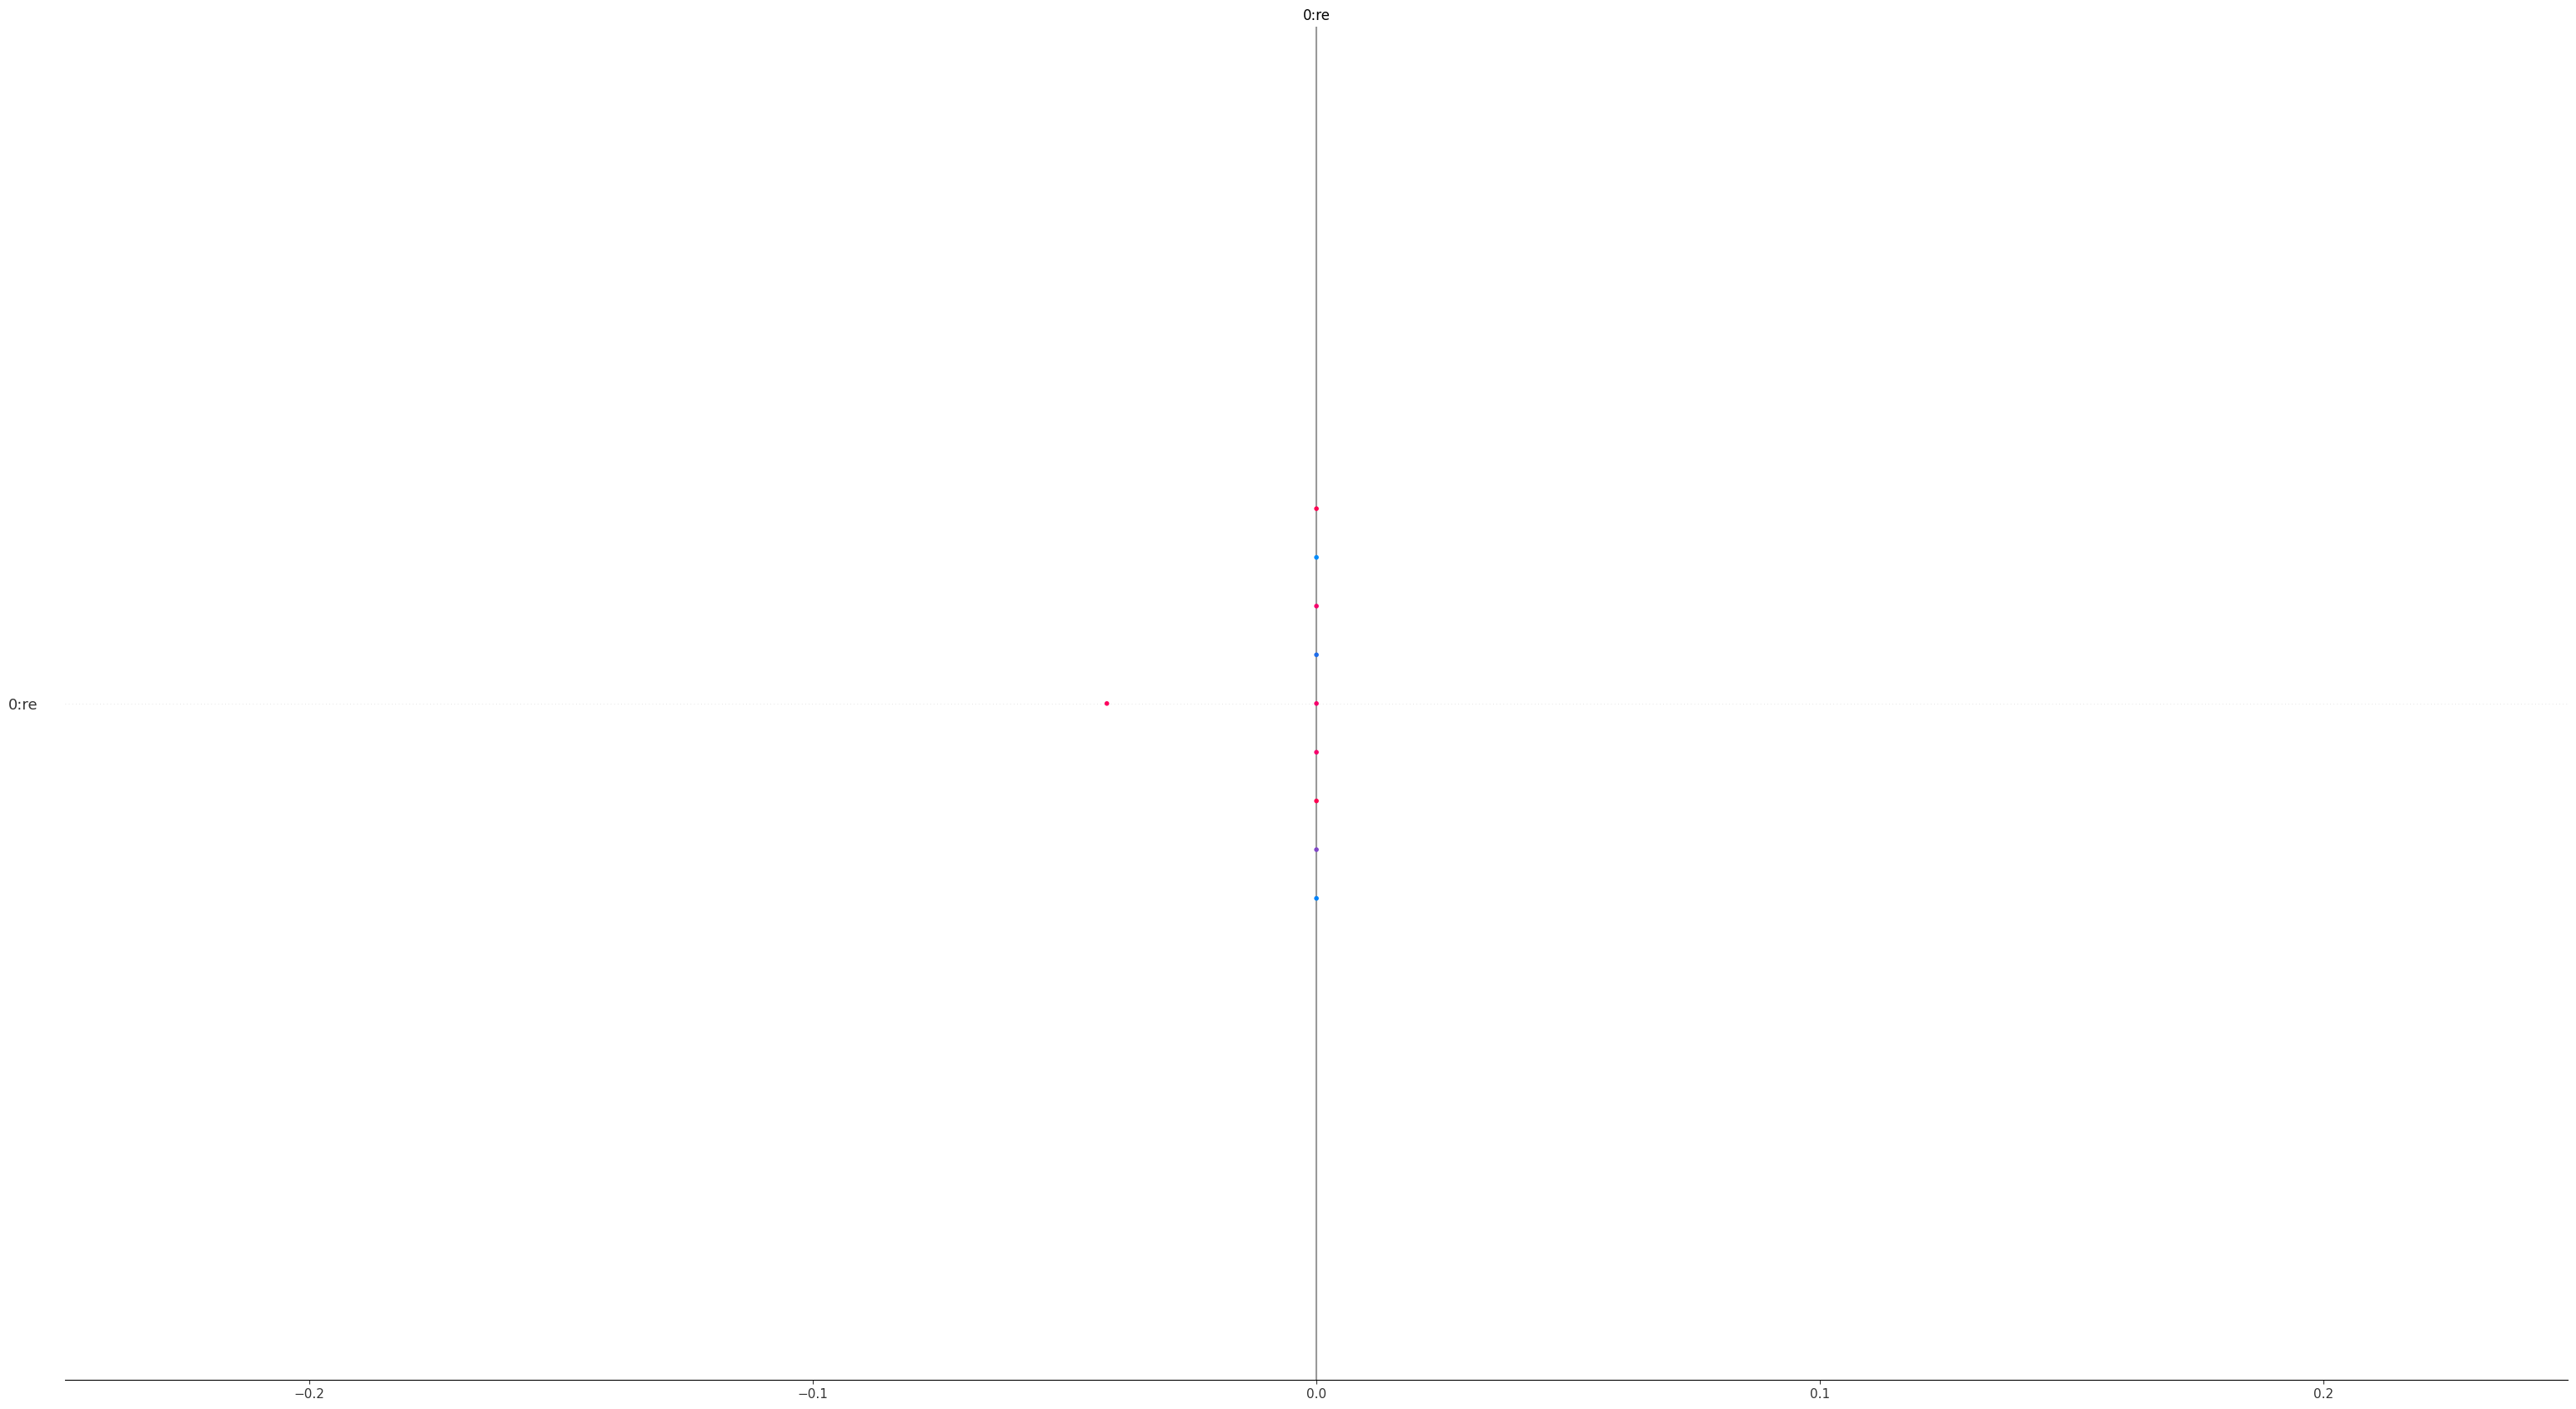

In [14]:
#
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    inputs_np,
    plot_type="bar",
    max_display=max_display,
    feature_names=feature_names,
    show=False
)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_29328\568016003.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
d:\projects\spam-detection2\.venv\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1200x800 with 0 Axes>

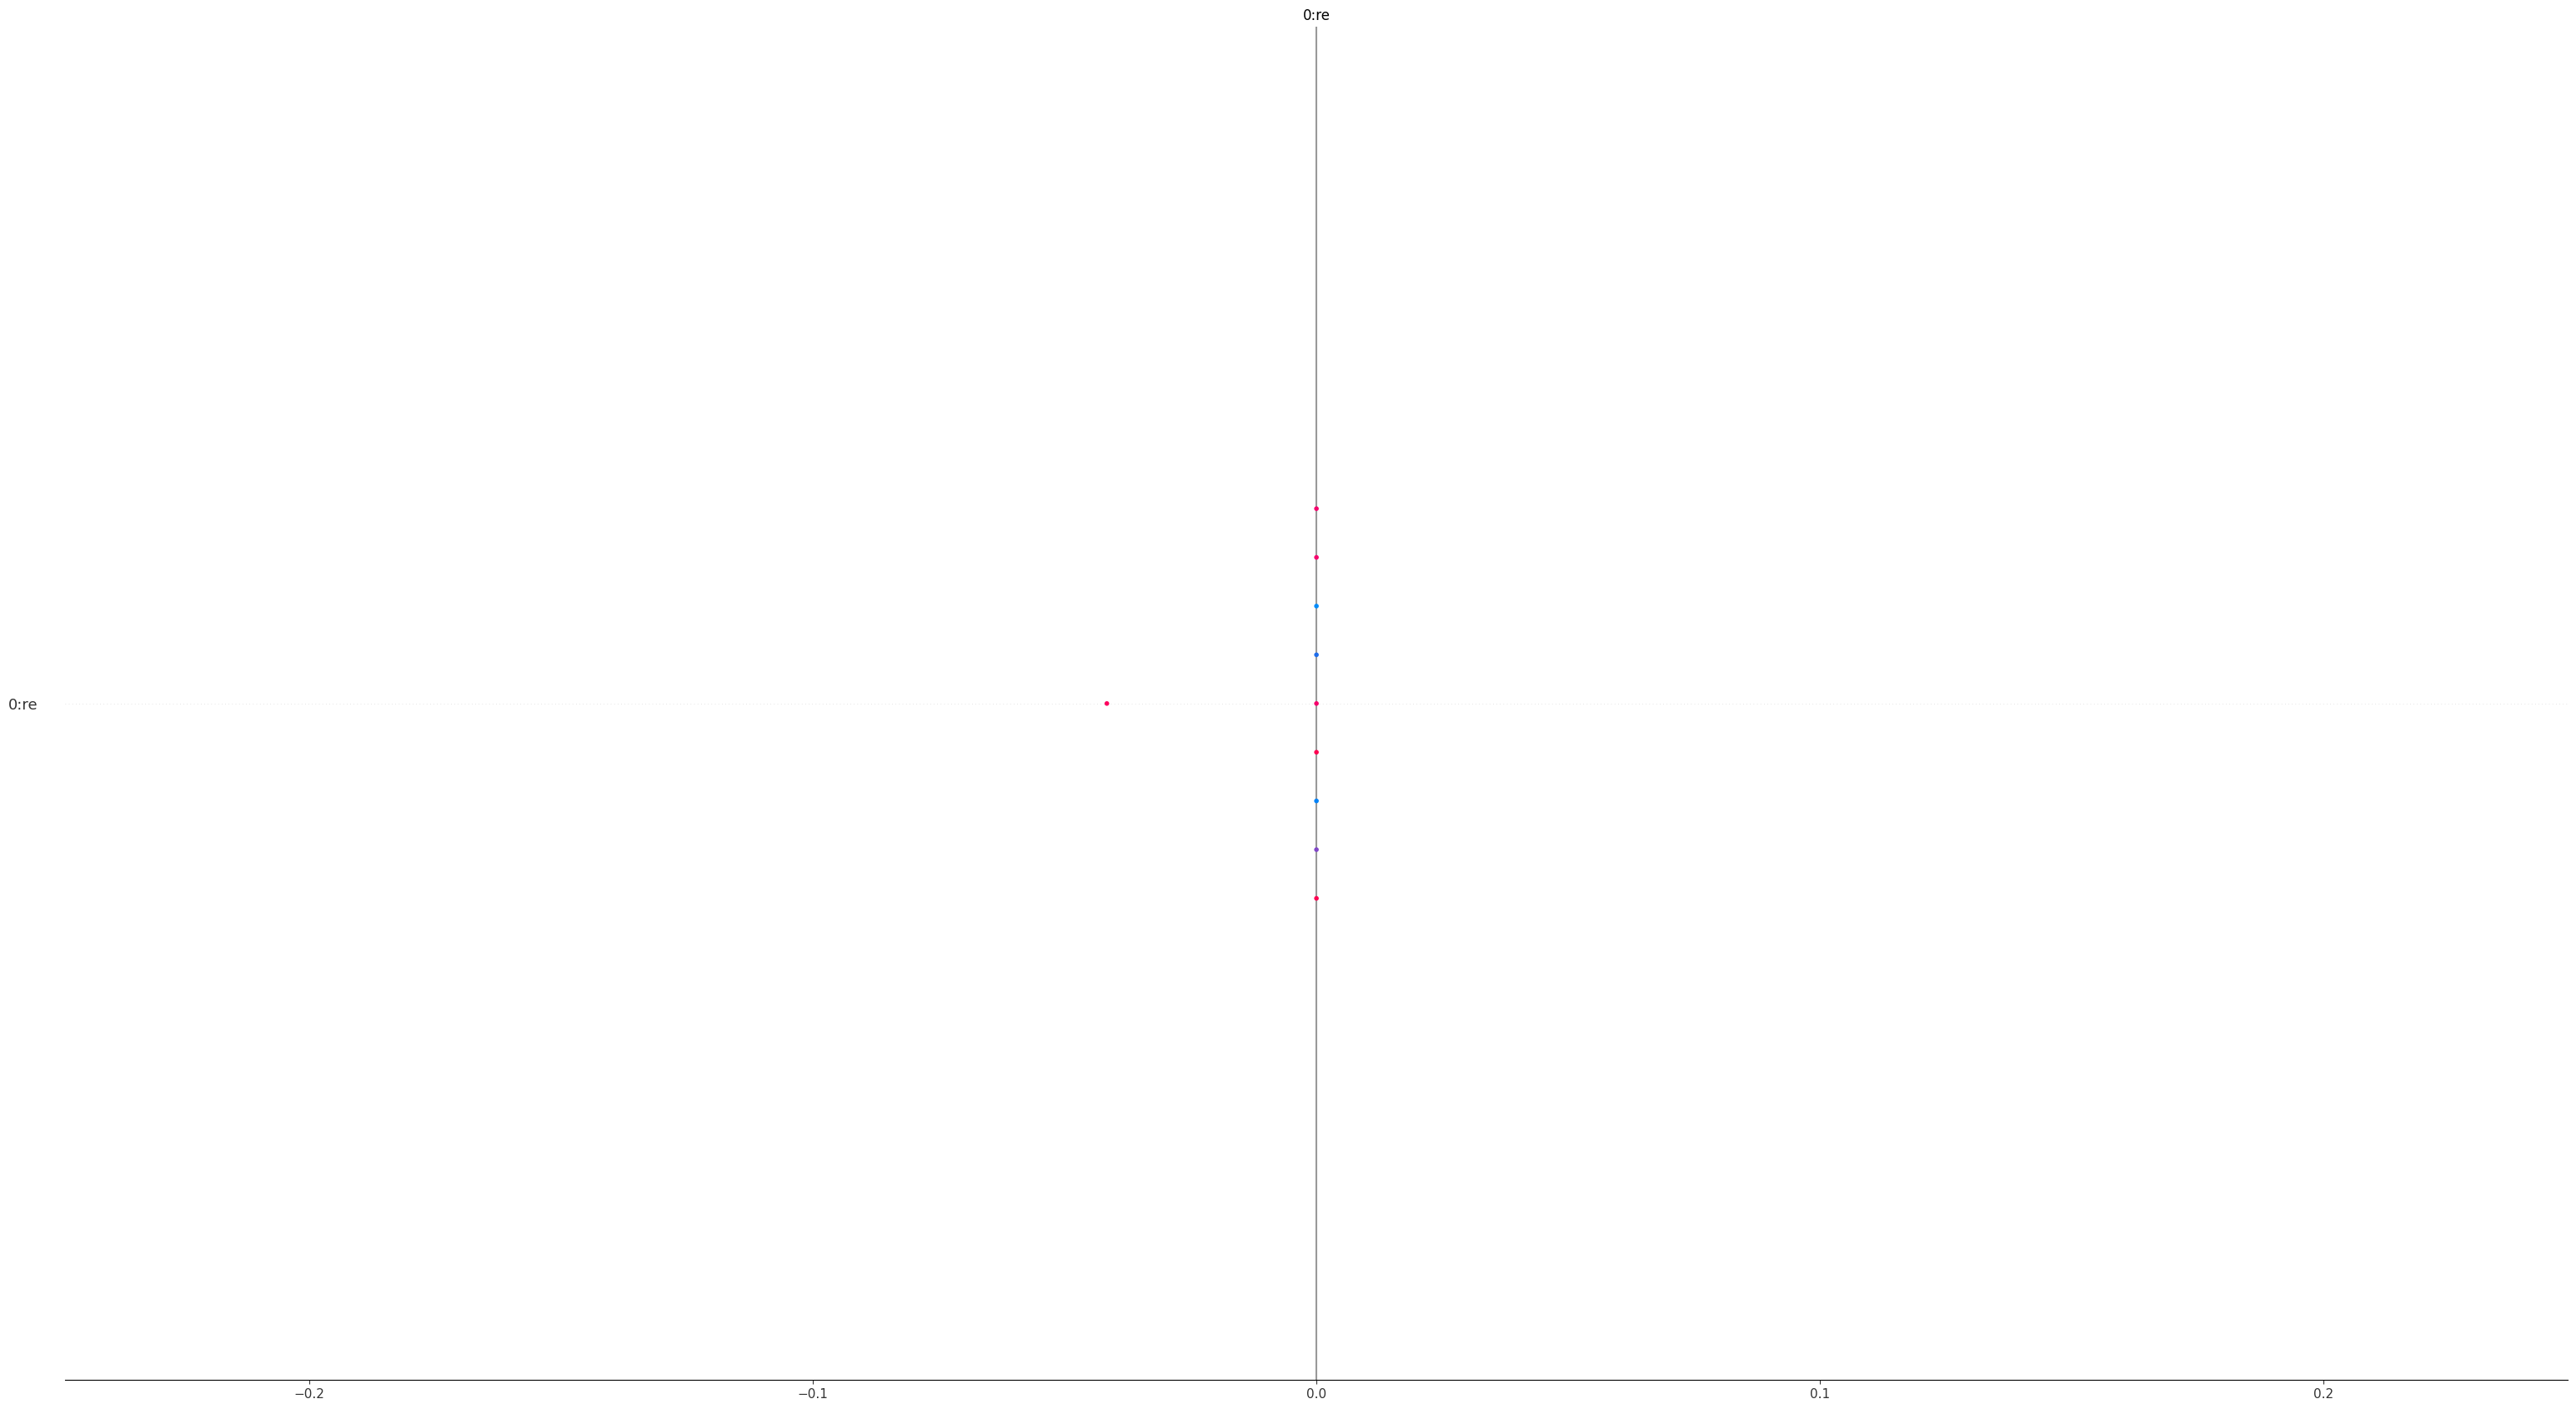

In [15]:
# Also show the dot plot for more detailed view with fewer samples
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    inputs_np,
    plot_type="dot",
    max_display=max_display,
    feature_names=feature_names,
    show=False
)
plt.tight_layout()
plt.show()

In [16]:
# Generate word cloud visualization of important features
sample_idx = 0  # Select a specific example to explain
plt.figure(figsize=(12, 4))

# Map token IDs to words for better understanding
words = map_token_ids_to_words(test_inputs[sample_idx].cpu().numpy())
word_shap_values = shap_values[sample_idx]

# Create a word-level explanation plot
shap.plots.text(word_shap_values, words, display=False)
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'output_names'

<Figure size 1200x400 with 0 Axes>

In [ ]:
# LIME explainability
lime_explainer = explain_cnn_with_lime(model, cnn_tokenizer, class_names=['ham', 'spam'], device=device, max_len=max_len)
lime_exp = lime_explainer(sample_texts[0])

lime_exp.show_in_notebook = show_in_notebook.__get__(lime_exp, lime_exp.__class__)

lime_exp.show_in_notebook(text=sample_texts[0], predict_proba=False)
# Save the LIME explanation as HTML for local viewing
# with open("lime_explanation.html", "w", encoding="utf-8") as f:
#     f.write(lime_exp.as_html())
# print("LIME explanation saved to lime_explanation.html. Open this file in your browser to view the explanation.")

